In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
root_dir = '/kaggle/input/mvtec-ad'
target_categories = ['cable', 'grid', 'metal_nut', 'screw', 'transistor']

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),    
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_datasets = []
test_datasets = []

In [5]:
print(f"Loading data from: {target_categories}")

for category in target_categories:
    category_train_dir = os.path.join(root_dir, category, 'train')
    category_test_dir = os.path.join(root_dir, category, 'test')

    if os.path.exists(category_train_dir) and os.path.exists(category_test_dir):
        # Train Data
        train_ds = ImageFolder(root=category_train_dir, transform=train_transform)
        train_ds.target_transform = lambda x: 0
        train_datasets.append(train_ds)

        # Test Data
        test_ds = ImageFolder(root=category_test_dir, transform=test_transform)
        if 'good' in test_ds.class_to_idx:
            good_idx = test_ds.class_to_idx['good']
            test_ds.target_transform = lambda x, idx=good_idx: 0 if x == idx else 1
        else:
            test_ds.target_transform = lambda x: 1
        test_datasets.append(test_ds)
    else:
        print(f"Path not found for category '{category}'")

if train_datasets and test_datasets:
    train_dataset = ConcatDataset(train_datasets)
    test_dataset = ConcatDataset(test_datasets)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    print(f"Total Train size: {len(train_dataset)}")
    print(f"Total Test size: {len(test_dataset)}")
else:
    print("Error: No valid datasets found.")

Loading data from: ['cable', 'grid', 'metal_nut', 'screw', 'transistor']
Total Train size: 1241
Total Test size: 603


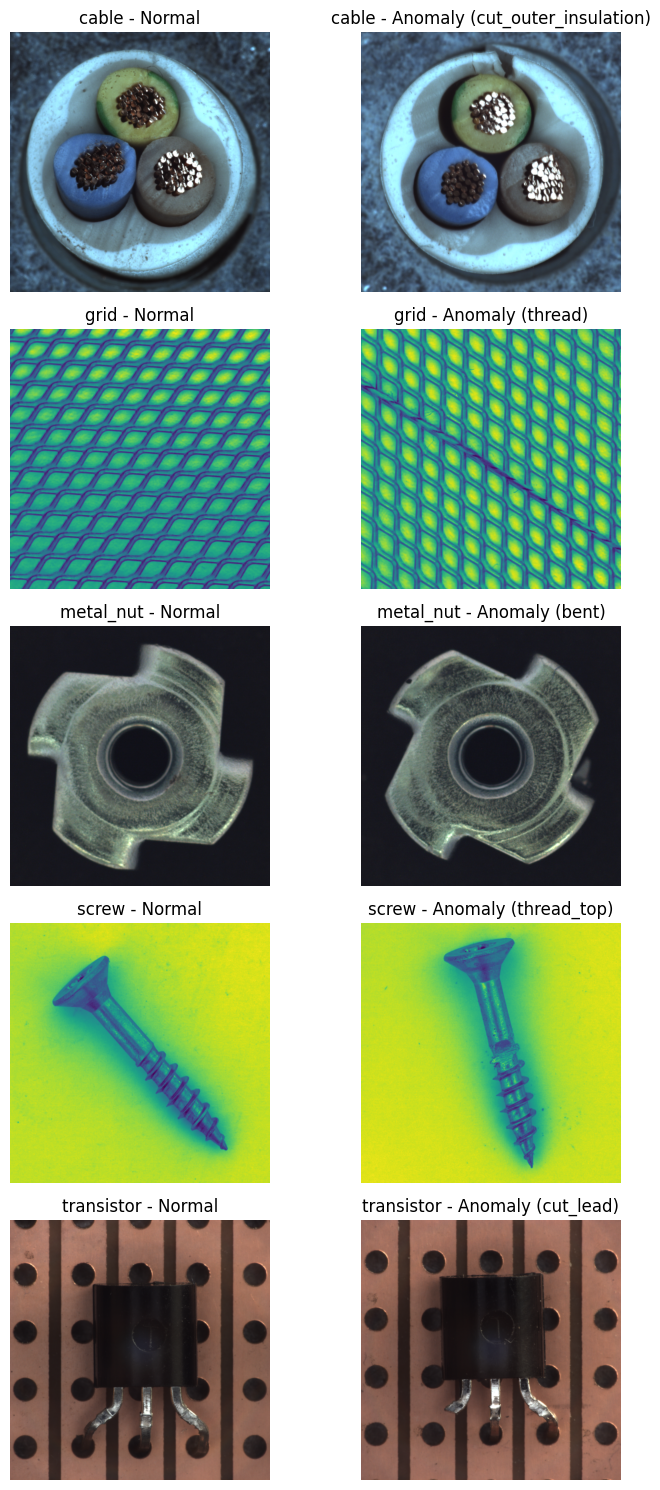

In [6]:
#visulise images
categories = ['cable', 'grid', 'metal_nut', 'screw', 'transistor']
fig, axes = plt.subplots(len(categories), 2, figsize=(8, 15))

for i, category in enumerate(categories):
    normal_path = glob.glob(os.path.join(root_dir, category, 'train', 'good', '*.png'))[0]
    
    test_root = os.path.join(root_dir, category, 'test')
    subfolders = [f for f in os.listdir(test_root) if os.path.isdir(os.path.join(test_root, f)) and f != 'good']
    anomaly_path = glob.glob(os.path.join(test_root, subfolders[0], '*.png'))[0]
    
    img_normal = Image.open(normal_path)
    img_anomaly = Image.open(anomaly_path)
    
    axes[i, 0].imshow(img_normal)
    axes[i, 0].set_title(f"{category} - Normal")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(img_anomaly)
    axes[i, 1].set_title(f"{category} - Anomaly ({subfolders[0]})")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.flatten_size = 256 * 14 * 14
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, self.flatten_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        
        z = self.decoder_input(z)
        z = z.view(-1, 256, 14, 14)
        
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

In [8]:
vae = VAE(latent_dim=512).to(device)
summary(vae, (3, 224, 224))

# Basic print (shows layers only)
print(vae)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           1,568
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         LeakyReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]          32,832
       BatchNorm2d-5           [-1, 64, 56, 56]             128
         LeakyReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 28, 28]         131,200
       BatchNorm2d-8          [-1, 128, 28, 28]             256
         LeakyReLU-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 14, 14]         524,544
      BatchNorm2d-11          [-1, 256, 14, 14]             512
        LeakyReLU-12          [-1, 256, 14, 14]               0
           Linear-13                  [-1, 512]      25,690,624
           Linear-14                  [

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    # Prevent infinite Loss if logvar explodes
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [12]:
print("Start training VAE...")
vae.train()

for epoch in range(40):
    overall_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        optimizer.zero_grad()

        recon_x, mu, logvar = vae(x)
        loss = vae_loss_function(recon_x, x, mu, logvar)
        
    
        if torch.isnan(loss):
            print(f"Warning: NaN loss detected at Epoch {epoch}. Skipping batch.")
            continue
            
        overall_loss += loss.item()
        
        loss.backward()
        
       
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        
        optimizer.step()
        
    avg_loss = overall_loss / len(train_loader.dataset)
    print(f"\tEpoch {epoch + 1} complete! \tAverage Loss: {avg_loss:.4f}")
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss: 1145.1612
	Epoch 2 complete! 	Average Loss: 1144.1611
Finish!!


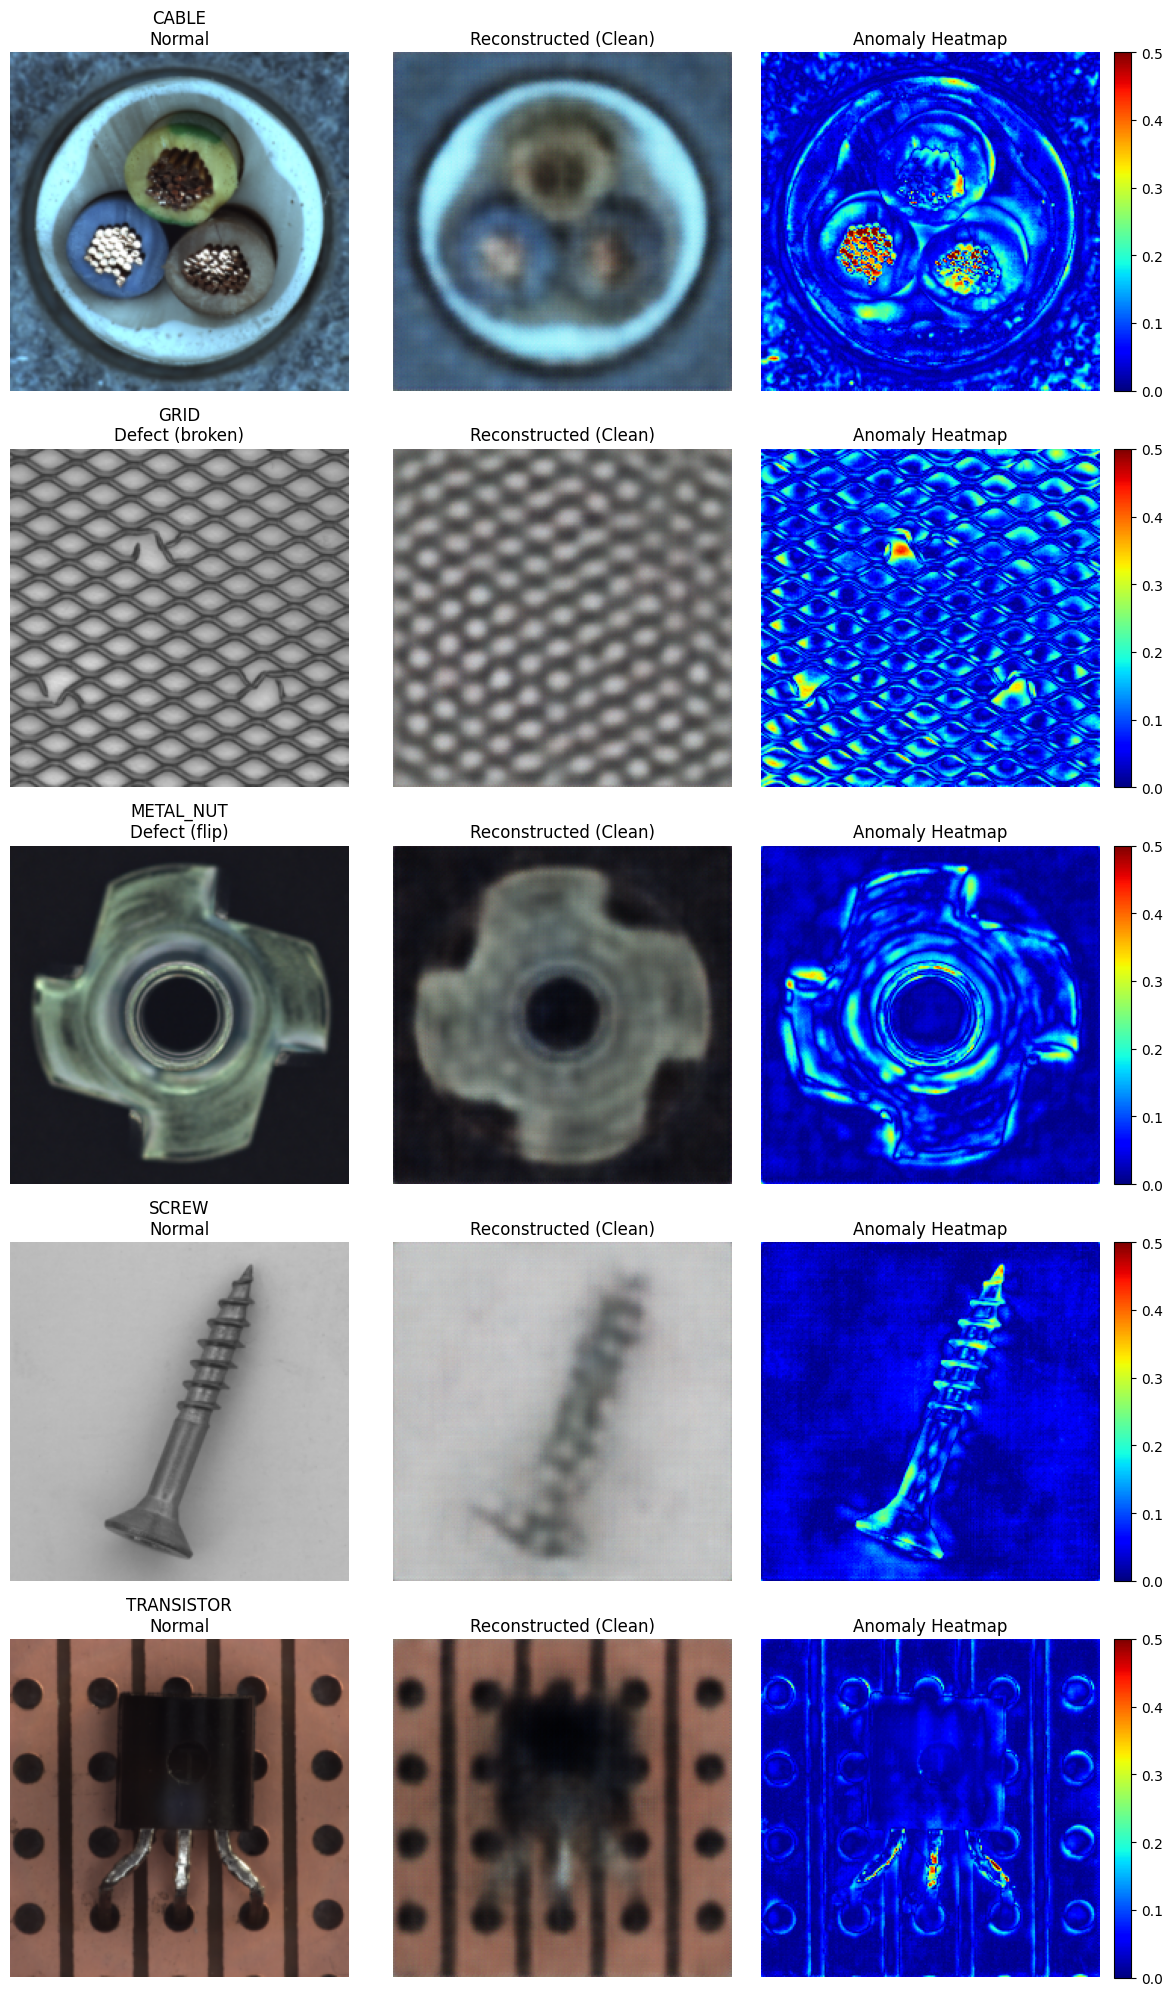

In [13]:
# Ensure model is in eval mode
vae.eval()

# Categories to test
target_categories = ['cable', 'grid', 'metal_nut', 'screw', 'transistor']

# Setup plot: 5 rows (one for each category), 3 columns (Original, Recon, Heatmap)
fig, axes = plt.subplots(len(target_categories), 3, figsize=(12, 4 * len(target_categories)))

with torch.no_grad():
    for i, category in enumerate(target_categories):
        
        # 1. Find a random image from the 'test' folder
        # We look inside all subfolders (good, scratch, etc.)
        test_root = os.path.join(root_dir, category, 'test')
        search_path = os.path.join(test_root, '*', '*.png')
        all_test_files = glob.glob(search_path)
        
        if not all_test_files:
            continue
            
        # Pick one random file
        img_path = random.choice(all_test_files)
        
        # Determine label based on folder name
        parent_folder = os.path.basename(os.path.dirname(img_path))
        label_text = "Normal" if parent_folder == 'good' else f"Defect ({parent_folder})"
        
        # 2. Load and Transform
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(img_pil).unsqueeze(0).to(device) # Add batch dimension
        
        # 3. VAE Inference
        recon_tensor, _, _ = vae(img_tensor)
        
        # 4. Calculate Error Map (Heatmap)
        # Absolute difference between input and reconstruction
        # We take the mean across the color channels (dim 1) to get a single intensity map
        error_map = torch.abs(img_tensor - recon_tensor).mean(dim=1).squeeze().cpu().numpy()
        
        # 5. Process Images for Display
        img_display = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        recon_display = recon_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        
        # 6. Plot Original
        ax_orig = axes[i, 0]
        ax_orig.imshow(img_display)
        ax_orig.set_title(f"{category.upper()}\n{label_text}")
        ax_orig.axis('off')
        
        # 7. Plot Reconstructed
        ax_recon = axes[i, 1]
        ax_recon.imshow(recon_display)
        ax_recon.set_title("Reconstructed (Clean)")
        ax_recon.axis('off')
        
        # 8. Plot Error Heatmap
        ax_heat = axes[i, 2]
        # vmin/vmax control the contrast. 'jet' is the classic heatmap color scheme.
        im = ax_heat.imshow(error_map, cmap='jet', vmin=0, vmax=0.5) 
        ax_heat.set_title("Anomaly Heatmap")
        ax_heat.axis('off')
        
        # Add a small colorbar next to the heatmap
        plt.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('vae_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def analyze_single_image(image_path, model, device):
    # 1. Load and Preprocess the Image
    try:
        img_pil = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Could not find image at {image_path}")
        return

    # Apply the same transform used during testing
    img_tensor = test_transform(img_pil).unsqueeze(0).to(device)
    
    # 2. Run Inference
    model.eval()
    with torch.no_grad():
        recon_tensor, _, _ = model(img_tensor)
        
        # Calculate Percentage Error (Mean Absolute Error)
        # We average the difference across all pixels and multiply by 100
        # 0.05 difference -> 5.00% error
        mae_error = torch.mean(torch.abs(img_tensor - recon_tensor)).item()
        error_percentage = mae_error * 100
        
        # Keep the raw MSE sum for scoring if needed
        mse_score = F.mse_loss(recon_tensor, img_tensor, reduction='sum').item()
        
        # Calculate Pixel-wise Error for Heatmap
        error_map = torch.abs(img_tensor - recon_tensor).mean(dim=1).squeeze().cpu().numpy()

    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # -- Original Image --
    img_display = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    axes[0].imshow(img_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # -- Reconstructed Image --
    recon_display = recon_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    axes[1].imshow(recon_display)
    axes[1].set_title("VAE Reconstruction")
    axes[1].axis('off')
    
    # -- Error Heatmap --
    im = axes[2].imshow(error_map, cmap='jet', vmin=0, vmax=0.5)
    axes[2].set_title(f"Anomaly Heatmap\nError: {error_percentage:.2f}%") # Show % here
    axes[2].axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    # Save the result (using the filename only, not the full path, to avoid errors)
    file_name = os.path.basename(image_path)
    save_name = f"result_{file_name}"
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"------------------------------------------------")
    print(f"Image Path: {image_path}")
    print(f"Reconstruction Error (MSE Sum): {mse_score:.4f}")
    print(f"Anomaly Percentage: {error_percentage:.2f}%")
    print(f"Saved result to: {save_name}")
    print(f"------------------------------------------------")

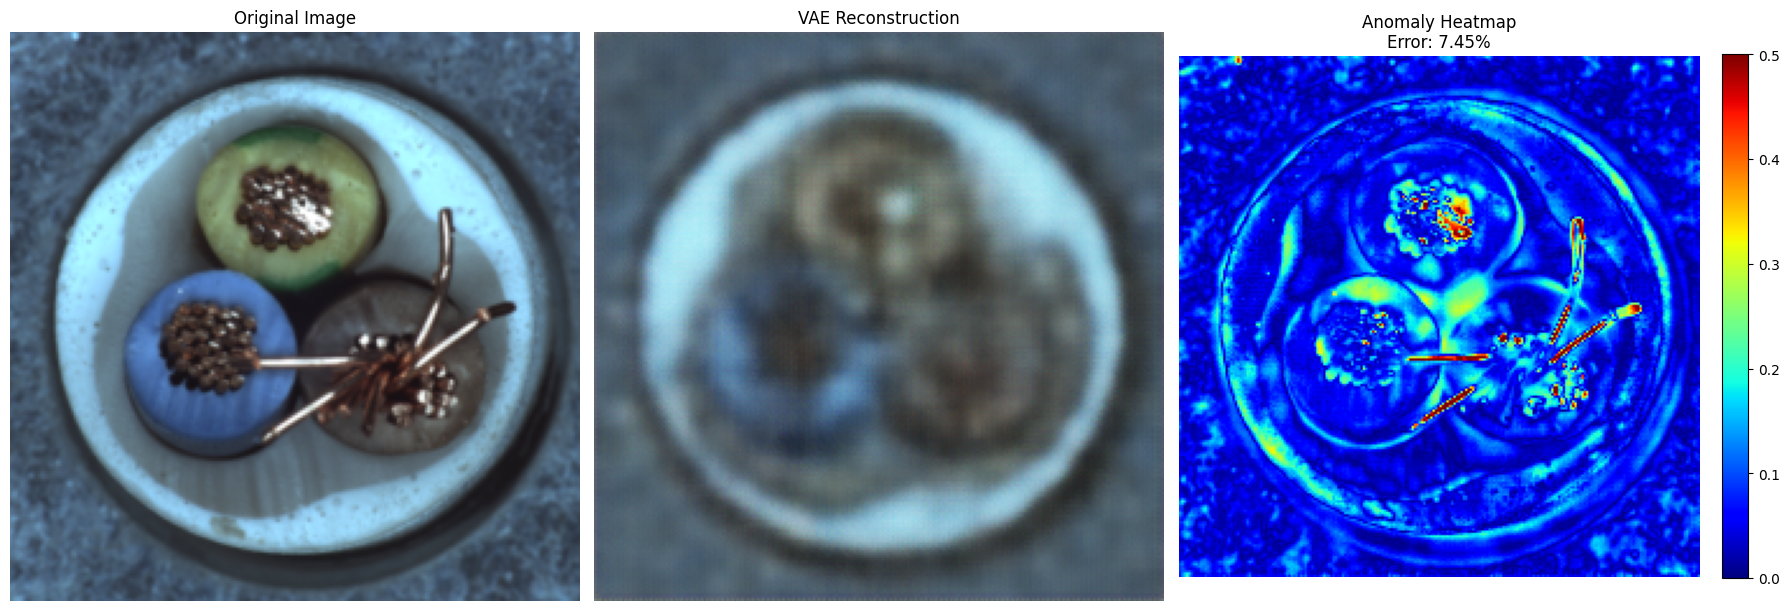

------------------------------------------------
Image Path: /kaggle/input/vae-test/cable_bad.png
Reconstruction Error (MSE Sum): 1628.7404
Anomaly Percentage: 7.45%
Saved result to: result_cable_bad.png
------------------------------------------------


In [21]:

target_image_path = '/kaggle/input/vae-test/cable_bad.png' 

analyze_single_image(target_image_path, vae, device)

Processing images...
  Week 1 processed. Rust Score: 4.91%
  Week 2 processed. Rust Score: 5.98%
  Week 3 processed. Rust Score: 6.87%


/tmp/ipykernel_217/3565060569.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Make room for colorbar



Analysis saved to: rust_progression_analysis.png


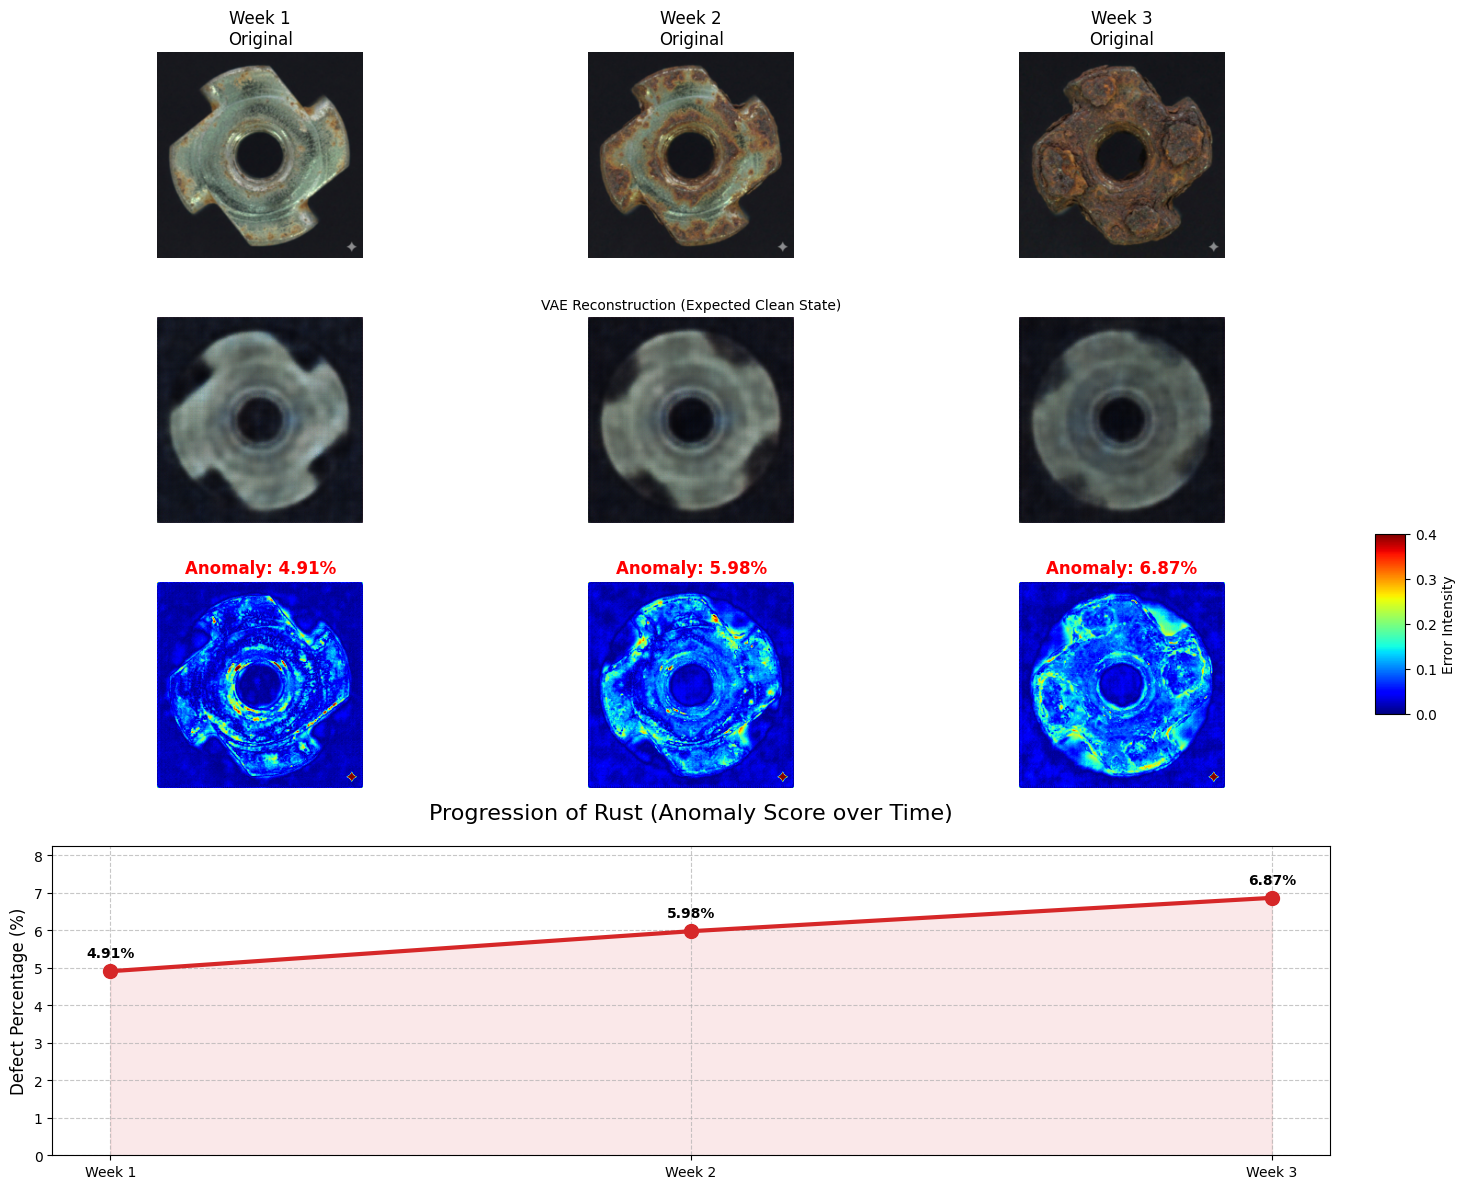

In [23]:
import matplotlib.gridspec as gridspec

def analyze_rust_progression(image_paths, model, device):
    """
    Analyzes 3 images representing Week 1, 2, and 3 of rust progression.
    Generates a dashboard with Heatmaps and a Time-Series Graph.
    """
    
    # Storage for plotting data
    original_images = []
    recon_images = []
    error_maps = []
    error_percentages = []
    weeks = ["Week 1", "Week 2", "Week 3"]
    
    model.eval()
    
    print("Processing images...")
    
    # --- 1. Loop through each week's image ---
    for i, path in enumerate(image_paths):
        # A. Load Image
        try:
            img_pil = Image.open(path).convert('RGB')
        except FileNotFoundError:
            print(f"Error: Could not find image at {path}")
            return

        # B. Transform & Inference
        img_tensor = test_transform(img_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            recon_tensor, _, _ = model(img_tensor)
            
            # C. Calculate Error Percentage (Mean Absolute Error * 100)
            mae = torch.mean(torch.abs(img_tensor - recon_tensor)).item()
            error_pct = mae * 100
            error_percentages.append(error_pct)
            
            # D. Prepare for visualization
            # Heatmap (mean across RGB channels)
            heatmap = torch.abs(img_tensor - recon_tensor).mean(dim=1).squeeze().cpu().numpy()
            
            # Convert tensors to numpy for plotting
            orig_np = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
            recon_np = recon_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
            
            original_images.append(orig_np)
            recon_images.append(recon_np)
            error_maps.append(heatmap)
            
            print(f"  {weeks[i]} processed. Rust Score: {error_pct:.2f}%")

    # --- 2. Create the Dashboard (Grid Layout) ---
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 1.5]) 
    # Rows: Orig, Recon, Heatmap, Graph
    
    # Plot Images (Rows 0-2)
    for i in range(3):
        # Row 0: Original
        ax_orig = plt.subplot(gs[0, i])
        ax_orig.imshow(original_images[i])
        ax_orig.set_title(f"{weeks[i]}\nOriginal", fontsize=12)
        ax_orig.axis('off')
        
        # Row 1: Reconstruction (Clean Reference)
        ax_recon = plt.subplot(gs[1, i])
        ax_recon.imshow(recon_images[i])
        if i == 1: ax_recon.set_title("VAE Reconstruction (Expected Clean State)", fontsize=10)
        ax_recon.axis('off')
        
        # Row 2: Heatmap
        ax_heat = plt.subplot(gs[2, i])
        im = ax_heat.imshow(error_maps[i], cmap='jet', vmin=0, vmax=0.4) # Fixed scale for comparison
        ax_heat.set_title(f"Anomaly: {error_percentages[i]:.2f}%", fontsize=12, fontweight='bold', color='red')
        ax_heat.axis('off')
        
    # Add Colorbar for Heatmaps
    cax = fig.add_axes([0.92, 0.4, 0.02, 0.15]) # Position [left, bottom, width, height]
    plt.colorbar(im, cax=cax, label='Error Intensity')

    # --- 3. Plot the Progression Graph (Row 3) ---
    ax_graph = plt.subplot(gs[3, :]) # Span all columns
    
    # Plot Line
    ax_graph.plot(weeks, error_percentages, marker='o', linestyle='-', linewidth=3, markersize=10, color='#d62728')
    
    # Fill area under line
    ax_graph.fill_between(weeks, error_percentages, color='#d62728', alpha=0.1)
    
    # Labels and Styling
    ax_graph.set_title("Progression of Rust (Anomaly Score over Time)", fontsize=16, pad=20)
    ax_graph.set_ylabel("Defect Percentage (%)", fontsize=12)
    ax_graph.set_ylim(0, max(error_percentages) * 1.2) # Dynamic Y-axis limit
    ax_graph.grid(True, linestyle='--', alpha=0.7)
    
    # Annotate points
    for i, txt in enumerate(error_percentages):
        ax_graph.annotate(f"{txt:.2f}%", (weeks[i], error_percentages[i]), 
                          xytext=(0, 10), textcoords='offset points', ha='center', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Make room for colorbar
    
    # Save and Show
    save_path = 'rust_progression_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nAnalysis saved to: {save_path}")
    plt.show()


week1_img = '/kaggle/input/vae-test/rust_1.png'
week2_img = '/kaggle/input/vae-test/rust_2.png'
week3_img = '/kaggle/input/vae-test/rust_3.png'

image_list = [week1_img, week2_img, week3_img]

analyze_rust_progression(image_list, vae, device)